# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import time
import re

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, label_binarize, MinMaxScaler, label_binarize
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
cohen_kappa_score,
matthews_corrcoef, 
make_scorer, 
f1_score,
accuracy_score,
balanced_accuracy_score, 
classification_report, 
confusion_matrix, 
precision_recall_curve, 
average_precision_score,
brier_score_loss,
roc_auc_score, 
roc_curve,
log_loss,
auc
)

from xgboost import XGBClassifier

from IPython.display import display

In [2]:
# CPU core usage for VM troubleshooting
import os
print(os.cpu_count())

16


# 2. Data Preprocessing

## 2.1. Data Loading

This cell scans the dataset folder for input CSV files (excluding previously generated combined outputs), reads each file into a DataFrame, concatenates them into one merged dataset, saves the merged CSV to disk, and loads it into `df` for cleaning and modeling.

In [3]:
# Directory containing the dataset CSV files
data_dir = Path("/datasets")

# Grab all csv files in directory
csv_files = sorted(
    f for f in data_dir.glob("*.csv")
    if f.name != "CICIDS2017_combined.csv" # Skip these output files to avoid re-reading & merging them
    if f.name != "CICIDS2017_combined_clean.csv"
)
print(f"Found {len(csv_files)} CSV files\n") # Log how many input files were discovered

dfs = [] # Holds each per-file DataFrame before concatenation
for f in csv_files:
    print("Reading:", f.name) # Log which file is being read
    df = pd.read_csv(f, low_memory=False) # To not infer dtypes in chunks
    dfs.append(df) # Store the DataFrame for later concatenation 

combined = pd.concat(dfs, ignore_index=True, sort=False) # Create a new index and keep original column order
print("\nCombined shape:", combined.shape) # Log rows and columns of the final merged DataFrame

out_path = data_dir / "CICIDS2017_combined.csv" # Output file path for the merged dataset
combined.to_csv(out_path, index=False) # To not write the DataFrame index as an extra column in the CSV
print("\nSaved to:", out_path) # Display where the combined CSV was written

# Load the combined CSV dataset into a DataFrame
df = pd.read_csv("/datasets/CICIDS2017_combined.csv", low_memory=False)
print("\nLoaded merged dataset into DataFrame")

Found 8 CSV files

Reading: Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Reading: Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Reading: Friday-WorkingHours-Morning.pcap_ISCX.csv
Reading: Monday-WorkingHours.pcap_ISCX.csv
Reading: Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Reading: Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Reading: Tuesday-WorkingHours.pcap_ISCX.csv
Reading: Wednesday-workingHours.pcap_ISCX.csv

Combined shape: (2830743, 79)

Saved to: /datasets/CICIDS2017_combined.csv

Loaded merged dataset into DataFrame


## 2.2. Data Preprocessing

### 2.2.1 BEFORE Clean-up

This cell runs a pre-cleaning quality check on the merged dataset, flagging header whitespace/collisions, string-based infinity tokens, NaN/Inf issues in rate features (and whether they come from Flow Duration = 0), duplicate rows, constant/all-zero columns, mixed dtypes, label formatting inconsistencies, and identifier-like columns that may cause leakage.

In [4]:
def _safe_df(rows, columns, sort_by=None, ascending=False):
    # To build a stable DataFrame (always same columns; safe if empty; optional sort)
    # If rows is empty, return an empty DataFrame with `columns`
    if not rows:
        return pd.DataFrame(columns=columns)
    d = pd.DataFrame(rows)
    # Ensures all `columns` exist (missing are filled with NaN)
    for c in columns:
        if c not in d.columns:
            d[c] = np.nan
    d = d[columns]
    # sort by sort_by if present
    if sort_by is not None and sort_by in d.columns:
        d = d.sort_values(sort_by, ascending=ascending)
    return d.reset_index(drop=True)

def qc_merged_report(df: pd.DataFrame, label_col: str | None = None, show_top: int = 25) -> dict:
    # To build a QC report, scan merged dataset for common data issues and return summary tables
    out = {}
    
    # ------ 1 - Column name cleanup (whitespace + collisions)
    raw_cols = df.columns.astype(str).tolist() # Original column headers as strings
    stripped_cols = [c.strip() for c in raw_cols] # Same headers after removing outer spaces
    whitespace_cols = [c for c in raw_cols if c != c.strip()] # Headers that actually change when stripped
    dup_after_strip_mask = pd.Series(stripped_cols).duplicated(keep=False) # Which stripped names repeat
    dup_after_strip_originals = sorted(set( # Original headers involved in collisions
        pd.Series(raw_cols)[dup_after_strip_mask].tolist()
    ))
    out["whitespace_cols"] = _safe_df( # Output table for original vs stripped
        [{"original": c, "stripped": c.strip()} for c in whitespace_cols],
        columns=["original", "stripped"],
        sort_by="original",
        ascending=True
    )
    out["duplicate_names_after_strip"] = dup_after_strip_originals  # Output headers that would clash after strip()
    col_map = {c: c.strip() for c in df.columns.astype(str)} # Mapping by original header to stripped header
    # Inverted mapping by normalized name to originals
    inv_map = {}
    for orig, stripped in col_map.items():
        inv_map.setdefault(stripped.lower(), []).append(orig) # Normalize case to match headers
    
    # ------ 2 - "Inf" tokens in text columns
    obj_cols = df.select_dtypes(include=["object"]).columns # Only scan object/text columns
    tokens = {"infinity", "inf", "+inf", "-inf"} # String forms treated as Infinity
    # Store columns that contain these tokens
    hits = []
    for c in obj_cols:
        s = df[c].astype(str).str.strip().str.lower() # Normalize text (string + trim + lowercase)
        mask = s.isin(tokens) # Rows where the value is an inf-token
        if mask.any(): # Only report columns with at least one hit
            hits.append({
                "column": c, # Which column has the issue
                "count_token_inf": int(mask.sum()), # How many inf-tokens appear
                "examples": df.loc[mask, c].head(5).tolist() # A few sample values for debugging
            })
    out["string_inf_cols"] = _safe_df( # Output as a clean, sortable table
        hits, ["column", "count_token_inf", "examples"],
        sort_by="count_token_inf", ascending=False # Show worst columns first
    )

    # ------ 3 - Rate features: NaN/Inf + divide-by-zero check
    rate_targets = ["flow bytes/s", "flow packets/s"] # The rate columns containing Infs when manually checked
    rate_rows = []
    for target in rate_targets:
        for col in inv_map.get(target, []): # Handle case/whitespace variants via inv_map
            num = pd.to_numeric(df[col], errors="coerce") # Force numeric by bad values to NaN
            n_total = len(df)
            n_nan = int(num.isna().sum()) # Count NaNs after conversion
            n_inf = int(np.isinf(num).sum()) # Count infinite values
            rate_rows.append({ # Store per-column summary
                "column": col,
                "n_nan": n_nan,
                "pct_nan": round(100 * n_nan / max(n_total, 1), 4),
                "n_inf": n_inf,
                "pct_inf": round(100 * n_inf / max(n_total, 1), 4),
            })
        if target not in inv_map: # If the expected feature is missing
            rate_rows.append({"column": f"(missing) {target}", "n_nan": None, "pct_nan": None, "n_inf": None, "pct_inf": None})
    out["rate_feature_issues"] = _safe_df( # Output table of NaN/Inf rates per feature
        rate_rows, ["column", "n_nan", "pct_nan", "n_inf", "pct_inf"],
        sort_by="column", ascending=True
    )
    # Check if bad rates are caused by Flow Duration == 0
    dur_col = (inv_map.get("flow duration") or [None])[0]
    if dur_col:
        dur_zero = (pd.to_numeric(df[dur_col], errors="coerce") == 0) # Rows where duration is zero
        corr_rows = []
        for target in rate_targets:
            for col in inv_map.get(target, []):
                num = pd.to_numeric(df[col], errors="coerce")
                bad = num.isna() | np.isinf(num) # “bad” = NaN or Inf
                corr_rows.append({
                    "duration_col_used": dur_col, # Which duration column were used
                    "rate_col": col, # Which rate column were tested
                    "bad_rate_rows": int(bad.sum()), # Total bad rows in this rate feature
                    "bad_when_dur_zero": int((bad & dur_zero).sum()), # Bad rows specifically when duration==0
                    "pct_bad_with_dur_zero": round(100 * (bad & dur_zero).sum() / max(bad.sum(), 1), 4),
                })
        out["rate_vs_duration_zero"] = _safe_df( # Output how strongly duration==0 explains bad rates
            corr_rows,
            ["duration_col_used", "rate_col", "bad_rate_rows", "bad_when_dur_zero", "pct_bad_with_dur_zero"],
            sort_by="bad_rate_rows", ascending=False
        )
    else:
        out["rate_vs_duration_zero"] = pd.DataFrame([{"note": "No Flow Duration column found."}])

    # ------ 4 - Duplicate rows
    n_dupes = int(df.duplicated().sum())
    out["duplicates_summary"] = { # Output amount of duplicate rows
        "rows": int(len(df)),
        "duplicate_rows": n_dupes,
        "pct_duplicates": round(100 * n_dupes / max(len(df), 1), 6)
    }

    # ------ 5 - Constant / all-zero features (no variance to no ML signal)
    rows = []
    for c in df.columns:
        nunq = int(df[c].nunique(dropna=False)) # Uniques incl. NaN, treating NaN as a value
        if nunq == 1: # Fully constant column
            rows.append({"column": c, "n_unique": 1, "value": df[c].iloc[0]})
        elif pd.api.types.is_numeric_dtype(df[c]) and (df[c].fillna(0) == 0).all():
            rows.append({"column": c, "n_unique": nunq, "value": "all_zero_or_nan"}) # Effectively constant
    out["constant_cols"] = _safe_df( # Output as a clean table
        rows, ["column", "n_unique", "value"],
        sort_by="column", ascending=True
    )
    
    # ------ 6 - Text columns that are mostly numeric
    rows = []
    for c in obj_cols:
        num = pd.to_numeric(df[c], errors="coerce") # Convert failures into NaN
        pct_num = 100 * float(num.notna().mean()) # % values that look numeric
        if pct_num >= 90: # Threshold to treat as numeric column
            examples = ( # Show a few values that failed conversion
                df.loc[num.isna(), c].astype(str).str.strip()
                  .replace({"nan": np.nan}).dropna().head(10).tolist()
            )
            rows.append({"column": c, "pct_numeric": round(pct_num, 3), "bad_examples": examples})
    out["object_numeric_suspects"] = _safe_df( # Output which object cols should be numeric
        rows, ["column", "pct_numeric", "bad_examples"],
        sort_by="pct_numeric", ascending=False
    )
    
    # ------ 7 - Label inconsistencies (same class written in different ways)
    if label_col is None: # Detect 'Label' column
        label_col = next((c for c in df.columns.astype(str) if c.strip().lower() == "label"), None)
    if label_col in df.columns: # Only run if label column exists
        raw = df[label_col].astype(str) # Original labels as-is
        norm = raw.str.strip().str.lower() # Normalized labels (trim + lowercase)
        # Count how many times each (raw, normalized) pair appears
        variants = pd.DataFrame({"raw": raw, "norm": norm}).value_counts().reset_index(name="count")
        # Group by normalized label to see which raw spellings map to the same class
        by_norm = (variants.groupby("norm", dropna=False)
                   .apply(lambda g: g.sort_values("count", ascending=False)[["raw", "count"]]
                          .head(show_top).to_dict("records"))
                   .reset_index(name="raw_variants"))
        out["label_col_used"] = label_col # Output which column was used
        out["label_inconsistencies"] = by_norm[by_norm["raw_variants"].apply(len).gt(1)].reset_index(drop=True)
        out["label_counts_normalized"] = norm.value_counts().head(50).to_frame("count") # Top classes
    else:
        out["label_col_used"] = None
        out["label_inconsistencies"] = pd.DataFrame([{"note": "No label column found."}])
        out["label_counts_normalized"] = pd.DataFrame()

    # ------ 8 - Identifier / leakage-like columns
    id_like = { # Common ID fields to flag
        "flow id", "timestamp",
        "src ip", "dst ip", "source ip", "destination ip",
        "src port", "dst port", "source port", "destination port",
        "protocol"
    }
    # Find any columns whose normalized name matches an ID-like field
    found = [orig for norm, originals in inv_map.items() if norm in id_like for orig in originals]
    out["identifier_cols_found"] = sorted(set(found)) # Output unique list with original column names
    
    # ------ 9 - Dtype summary
    out["dtype_summary"] = df.dtypes.astype(str).value_counts().to_frame("n_columns")
    return out

# Run QC and display outputs
qc = qc_merged_report(df)

print("---- 1 - Columns with leading/trailing whitespace")
print(qc["whitespace_cols"].head(200))
print("\n---- 1b - Potential collisions after stripping (original names involved)")
print(qc["duplicate_names_after_strip"])

print("\n---- 2 - 'Infinity/inf' tokens found in OBJECT columns")
print(qc["string_inf_cols"].head(50))  # will be empty (no crash) if none found

print("\n---- 3 - Rate feature NaN/Inf issues (Flow Bytes/s, Flow Packets/s)")
print(qc["rate_feature_issues"])
print("\n---- 3b - Bad rate values vs Flow Duration == 0 (if Flow Duration exists)")
print(qc["rate_vs_duration_zero"].head(50))

print("\n---- 4 - Duplicate rows summary")
print(qc["duplicates_summary"])

print("\n---- 5 - Constant / all-zero columns")
print(qc["constant_cols"].head(100))

print("\n---- 6 - Object columns that are mostly numeric (dtype issues)")
print(qc["object_numeric_suspects"].head(50))

print("\n---- 7 - Label inconsistencies (raw variants mapping to same normalized label)")
print("Label column used:", qc["label_col_used"])
print(qc["label_inconsistencies"].head(50))
print("\n---- 7b - Normalized label counts (top 50)")
print(qc["label_counts_normalized"].head(50))

print("\n---- 8 - Identifier-like columns found (possible leakage)")
print(qc["identifier_cols_found"])

print("\n---- 9 - Dtype summary")
print(qc["dtype_summary"])

---- 1 - Columns with leading/trailing whitespace
                        original                     stripped
0                 ACK Flag Count               ACK Flag Count
1                     Active Max                   Active Max
2                     Active Min                   Active Min
3                     Active Std                   Active Std
4            Average Packet Size          Average Packet Size
..                           ...                          ...
60             Total Fwd Packets            Total Fwd Packets
61   Total Length of Bwd Packets  Total Length of Bwd Packets
62                URG Flag Count               URG Flag Count
63              act_data_pkt_fwd             act_data_pkt_fwd
64          min_seg_size_forward         min_seg_size_forward

[65 rows x 2 columns]

---- 1b - Potential collisions after stripping (original names involved)
[]

---- 2 - 'Infinity/inf' tokens found in OBJECT columns
Empty DataFrame
Columns: [column, count_token_inf,

/tmp/ipykernel_8902/549497848.py:154: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sort_values("count", ascending=False)[["raw", "count"]]


### 2.2.2 AFTER Clean-up

This cell reports the dataset quality after cleaning by summarising the final shape, confirming duplicates and constant/all-zero columns were removed, verifying Flow Bytes/s and Flow Packets/s no longer contain invalid values (e.g. Flow Duration = 0), and checking that label values are consistently formatted before saving and reloading the cleaned dataset.

In [5]:
def find_col(df, name: str):
    # Robust column lookup, ignore whitespace and case, return the real header or None
    target = name.strip().lower()
    return next((c for c in df.columns if str(c).strip().lower() == target), None)

def constant_or_zero_cols(df):
    # Find 'no-signal' columns, constant (1 unique incl NaN) OR numeric all 0/NaN
    cols = []
    for c in df.columns:
        if df[c].nunique(dropna=False) == 1: # Fully constant
            cols.append(c)
        elif pd.api.types.is_numeric_dtype(df[c]) and (df[c].fillna(0) == 0).all():
            cols.append(c) # Effectively constant (all 0/NaN)
    return sorted(set(cols))

def report_key_stats(df, title=""):
    # Quick before/after QC snapshot (shape, dupes, no-signal cols, rate sanity, label preview)
    print(f"\n{'-'*60}\n{title}\n{'-'*60}")
    dup = int(df.duplicated().sum())
    print("Shape:", df.shape, "| Duplicate rows:", dup, f"({100*dup/max(len(df),1):.4f}%)")
    const_cols = constant_or_zero_cols(df) # Columns safe to drop
    print("Constant/all-zero cols:", len(const_cols),
          (f"| ex: {const_cols[:10]}" if const_cols else ""))
    # Fix rate features when duration==0 (avoid NaN/Inf from divide-by-zero)
    dur = find_col(df, "Flow Duration")
    fb  = find_col(df, "Flow Bytes/s")
    fp  = find_col(df, "Flow Packets/s")
    if dur and (fb or fp):
        dur_zero = (pd.to_numeric(df[dur], errors="coerce") == 0)
        for col in [fb, fp]:
            if not col:
                continue
            x = pd.to_numeric(df[col], errors="coerce")
            bad = x.isna() | np.isinf(x)
            print(f"{col}: bad={int(bad.sum())}  bad&dur0={int((bad & dur_zero).sum())}")
    else:
        print("Rate check skipped (missing duration and/or rate columns).")
    # Label preview in normalized counts to spot casing/whitespace variants
    lab = find_col(df, "Label")
    if lab:
        print("Label column:", repr(lab))
        print(df[lab].astype(str).str.strip().str.lower().value_counts().head(12))
    else:
        print("No Label column found.")
    return const_cols

# ---- BEFORE Report
_ = report_key_stats(df, "BEFORE CLEANING")

# ---- CLEANING PIPELINE
df = df.copy()

df.columns = df.columns.astype(str).str.strip()                  # 1. Trim header whitespace
df = df.drop_duplicates().reset_index(drop=True)                 # 2. Remove duplicate rows
df = df.drop(columns=constant_or_zero_cols(df), errors="ignore") # 3. Drop no-signal features

# 4. Fix rate features when duration==0 (avoid NaN/Inf from divide-by-zero)
FIX_RATE_MODE = "set_zero"
dur = find_col(df, "Flow Duration")
fb  = find_col(df, "Flow Bytes/s")
fp  = find_col(df, "Flow Packets/s")
if dur and (fb or fp):
    dur_zero = (pd.to_numeric(df[dur], errors="coerce") == 0) # Duration==0 rows
    for col in [fb, fp]:
        if not col:
            continue
        x = pd.to_numeric(df[col], errors="coerce").replace([np.inf, -np.inf], np.nan)  # Unify bad values
        bad = x.isna() # After replace bad == NaN
        if FIX_RATE_MODE == "set_zero":
            x.loc[dur_zero & bad] = 0.0 # Set bad rates to 0 when duration==0
            df[col] = x
        elif FIX_RATE_MODE == "drop_rows":
            df = df.loc[~(dur_zero & bad)].reset_index(drop=True) # Drop those rows entirely
        else:
            raise ValueError("FIX_RATE_MODE must be 'set_zero' or 'drop_rows'")

# 5. Label cleanup and standardization
lab = find_col(df, "Label")
if lab:
    df[lab] = (df[lab].astype(str).str.strip() # Trim whitespace
               .str.replace("�", "-", regex=False) # Fix encoding artifact
               .str.replace(r"\s+", " ", regex=True)) # Collapse repeated spaces
    label_map = { # Normalize common label variants
        "web attack - brute force": "Web Attack - Brute Force",
        "web attack - xss": "Web Attack - XSS",
        "web attack - sql injection": "Web Attack - SQL Injection",
        "benign": "BENIGN",
        "ddos": "DDoS",
        "bot": "Bot",
        "portscan": "PortScan",
        "infiltration": "Infiltration",
        "heartbleed": "Heartbleed",
        "dos hulk": "DoS Hulk",
        "dos slowloris": "DoS Slowloris",
        "dos slowhttptest": "DoS SlowHTTPTest",
        "dos goldeneye": "DoS GoldenEye",
    }
    df[lab] = df[lab].apply(lambda s: label_map.get(s.lower(), s)) # Apply mapping safely

# ---- AFTER Report
_ = report_key_stats(df, "AFTER CLEANING")
print("Total NaN cells:", int(df.isna().sum().sum())) # Quick sanity check

# Save and reload
path = "/datasets/CICIDS2017_combined_clean.csv"
df.to_csv(path, index=False); print("Saved:", path)
df = pd.read_csv(path, low_memory=False); print("Reloaded:", path)


------------------------------------------------------------
BEFORE CLEANING
------------------------------------------------------------
Shape: (2830743, 79) | Duplicate rows: 308381 (10.8940%)
Constant/all-zero cols: 8 | ex: [' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', ' Bwd PSH Flags', ' Bwd URG Flags', ' Fwd Avg Bulk Rate', ' Fwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 'Fwd Avg Bytes/Bulk']
Flow Bytes/s: bad=2867  bad&dur0=2867
 Flow Packets/s: bad=2867  bad&dur0=2867
Label column: ' Label'
 Label
benign                      2273097
dos hulk                     231073
portscan                     158930
ddos                         128027
dos goldeneye                 10293
ftp-patator                    7938
ssh-patator                    5897
dos slowloris                  5796
dos slowhttptest               5499
bot                            1966
web attack � brute force       1507
web attack � xss                652
Name: count, dtype: int64

-----------------------------

## 2.3. Feature Engineering

This cell coerces key columns to numeric, fixes negative/zero-duration artifacts and rate infinities, creates additional engineered traffic features (volume, ratios, timing variability, flags, port categories, log transforms), then performs a final cleanup pass to replace any remaining inf/NaN in engineered columns so the dataset is fully numeric and model-ready.

In [6]:
# ---- 1 - Ensure key columns are numeric
for col in [
    "Flow Duration", "Flow Bytes/s", "Flow Packets/s",
    "Total Fwd Packets", "Total Backward Packets",
    "Total Length of Fwd Packets", "Total Length of Bwd Packets",
    "Flow IAT Std", "Flow IAT Mean",
    "Fwd IAT Std", "Fwd IAT Mean",
    "Bwd IAT Std", "Bwd IAT Mean",
    "Active Mean", "Idle Mean",
    "SYN Flag Count", "RST Flag Count", "ACK Flag Count",
    "Destination Port"
]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# ---- 2 - Fix negative Flow Duration before log transforms
df["Flow Duration"] = df["Flow Duration"].fillna(0).clip(lower=0)

# ---- 3 - Fix rates when Flow Duration == 0
dur_zero = df["Flow Duration"].eq(0)
for rate_col in ["Flow Bytes/s", "Flow Packets/s"]:
    if rate_col in df.columns:
        x = df[rate_col].replace([np.inf, -np.inf], np.nan)
        # If duration==0 and rate is missing/inf, set it to 0
        x.loc[dur_zero & x.isna()] = 0.0
        df[rate_col] = x.fillna(0)  # Keep fully numeric

# ---- 4 - Feature engineering
eps = 1e-6 # small constant to avoid divide-by-zero

df["total_packets"] = df["Total Fwd Packets"].fillna(0) + df["Total Backward Packets"].fillna(0)
df["total_bytes"] = df["Total Length of Fwd Packets"].fillna(0) + df["Total Length of Bwd Packets"].fillna(0)

# Directional ratios 
df["fwd_bwd_pkt_ratio"] = (df["Total Fwd Packets"].fillna(0) + 1) / (df["Total Backward Packets"].fillna(0) + 1) # Added 1 to avoid divide-by-zero and to keep scale stable
df["fwd_bwd_byte_ratio"] = (df["Total Length of Fwd Packets"].fillna(0) + 1) / (df["Total Length of Bwd Packets"].fillna(0) + 1)

# Size-per-packet features
df["bytes_per_packet"] = df["total_bytes"] / (df["total_packets"] + 1)
df["fwd_bytes_per_packet"] = df["Total Length of Fwd Packets"].fillna(0) / (df["Total Fwd Packets"].fillna(0) + 1)
df["bwd_bytes_per_packet"] = df["Total Length of Bwd Packets"].fillna(0) / (df["Total Backward Packets"].fillna(0) + 1)

# Variability features
df["flow_iat_cv"] = df["Flow IAT Std"].fillna(0) / (df["Flow IAT Mean"].fillna(0) + eps)
df["fwd_iat_cv"] = df["Fwd IAT Std"].fillna(0) / (df["Fwd IAT Mean"].fillna(0) + eps)
df["bwd_iat_cv"] = df["Bwd IAT Std"].fillna(0) / (df["Bwd IAT Mean"].fillna(0) + eps)

# Activity vs idle
df["active_fraction"] = df["Active Mean"].fillna(0) / (df["Active Mean"].fillna(0) + df["Idle Mean"].fillna(0) + 1)

# Flag counts normalized by flow size
df["syn_per_packet"] = df["SYN Flag Count"].fillna(0) / (df["total_packets"] + 1)
df["rst_per_packet"] = df["RST Flag Count"].fillna(0) / (df["total_packets"] + 1)
df["ack_per_packet"] = df["ACK Flag Count"].fillna(0) / (df["total_packets"] + 1)
df["syn_ack_imbalance"] = (df["SYN Flag Count"].fillna(0) - df["ACK Flag Count"].fillna(0)) / (df["total_packets"] + 1)

# Port categorisation
ports = df["Destination Port"].fillna(-1) # Fill NaNs with -1 so that port-range comparisons behave predictably
df["port_well_known"] = (ports.between(0, 1023)).astype(int)
df["port_registered"] = (ports.between(1024, 49151)).astype(int)
df["port_dynamic"] = (ports >= 49152).astype(int)

# Log transforms
df["log_flow_duration"] = np.log1p(df["Flow Duration"])
df["log_total_bytes"] = np.log1p(df["total_bytes"].clip(lower=0))
df["log_total_packets"] = np.log1p(df["total_packets"].clip(lower=0))
df["log_flow_bytes_per_s"] = np.log1p(df["Flow Bytes/s"].clip(lower=0))
df["log_flow_packets_per_s"] = np.log1p(df["Flow Packets/s"].clip(lower=0))

# ---- 5 - Final safety pass by removing inf/nan in feature engineered columns
engineered_cols = [
    "total_packets", "total_bytes",
    "fwd_bwd_pkt_ratio", "fwd_bwd_byte_ratio",
    "bytes_per_packet", "fwd_bytes_per_packet", "bwd_bytes_per_packet",
    "flow_iat_cv", "fwd_iat_cv", "bwd_iat_cv", "active_fraction",
    "syn_per_packet", "rst_per_packet", "ack_per_packet", "syn_ack_imbalance",
    "port_well_known", "port_registered", "port_dynamic",
    "log_flow_duration", "log_total_bytes", "log_total_packets",
    "log_flow_bytes_per_s", "log_flow_packets_per_s"
]
df[engineered_cols] = (
    df[engineered_cols]
      .replace([np.inf, -np.inf], np.nan)
      .fillna(0)
)

print("Inf in engineered cols:", np.isinf(df[engineered_cols].to_numpy()).sum())
print("NaN in engineered cols:", np.isnan(df[engineered_cols].to_numpy()).sum())

Inf in engineered cols: 0
NaN in engineered cols: 0


## 2.4. Train-Test Split

This cell separates features and labels, encodes the multiclass target, performs a stratified 75/25 train-test split, applies Min–Max scaling fitted on the training set only, checks class coverage/distribution in both splits, and computes capped class-balanced sample weights from the training set for use during model training.

In [7]:
# Prepare feature matrix X and multiclass target y for 75/25 stratified hold-out split
RANDOM_STATE = 42
TARGET_COL = "Label"

# ---- 1 - Split features (X) and target labels (y_raw)
X = df.drop(columns=[TARGET_COL]).copy() # All input features, excluding the target column
y_raw = df[TARGET_COL].astype(str).copy() # Raw label values as strings, kept separate from X

# ---- 2 - Encode string labels into integer class IDs (0 to n_classes-1)
le = LabelEncoder() # Learn the mapping from each unique label string to an integer ID
y = le.fit_transform(y_raw) # Convert y_raw into numeric class IDs for modeling
class_names = le.classes_ # Unique label names in the encoder, ordered by assigned class ID
n_classes = len(class_names) # Total number of classes
print("Number of classes:", n_classes)
print("Top label counts:\n", y_raw.value_counts().head(10))

# ---- 3 - Train/test split (75/25), stratified to preserve class proportions
TEST_SIZE = 0.25
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    stratify=y, # Preserve class distribution
    shuffle=True, # Not time-series data
    random_state=RANDOM_STATE
)
print("\nSplit summary:")
print(f"  Training set: {X_train.shape[0]} rows ({(1-TEST_SIZE)*100:.0f}%), {X_train.shape[1]} features")
print(f"  Test set:     {X_test.shape[0]} rows ({TEST_SIZE*100:.0f}%), {X_test.shape[1]} features")

# ---- 3b - Min-Max scale features (fit on TRAIN only to avoid leakage)
scaler = MinMaxScaler()
X_train_raw = X_train.copy() # Keep unscaled copies
X_test_raw  = X_test.copy()
X_train_mm = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_mm  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns,  index=X_test.index)
# Use scaled features for modeling
X_train_model = X_train_mm
X_test_model  = X_test_mm

# ---- 4 - Sanity check on train/test class distributions and missing classes
train_counts = np.bincount(y_train, minlength=n_classes)
test_counts  = np.bincount(y_test, minlength=n_classes)
train_dist = train_counts / len(y_train)
test_dist  = test_counts / len(y_test)

print("\nClass distribution check (top 10 classes):")
for i in np.argsort(-train_dist)[:10]:
    print(f"  {class_names[i]:25s} train={train_dist[i]:.4%}  test={test_dist[i]:.4%}")

# Ensure every class appears in both splits for small classes
missing_in_train = [class_names[i] for i in range(n_classes) if train_counts[i] == 0]
missing_in_test  = [class_names[i] for i in range(n_classes) if test_counts[i] == 0]
print("\nClasses missing in TRAIN:", missing_in_train)
print("Classes missing in TEST:", missing_in_test)

print("\nRarest classes (bottom 5 by TRAIN count):")
for i in np.argsort(train_counts)[:5]:
    print(f"  {class_names[i]:25s} train_count={train_counts[i]:6d}  test_count={test_counts[i]:6d}")

tiny_threshold = 20
tiny_classes = [class_names[i] for i in range(n_classes) if train_counts[i] < tiny_threshold]
print(f"\nClasses with < {tiny_threshold} training samples:", tiny_classes)

# ---- 5 - Class-balanced sample weights from TRAIN only
class_weights = (len(y_train) / (n_classes * np.maximum(train_counts, 1)))

sample_weight_train = class_weights[y_train] # Assign each training sample the weight of its class

# Capping extreme weights so that rare classes like Heartbleed don't dominate training
MAX_W = 1000 
sample_weight_train = np.clip(sample_weight_train, 0, MAX_W)

print("\nClass weight examples (first 10 classes):")
for i in range(min(10, n_classes)):
    print(f"  {class_names[i]:25s} count={train_counts[i]:7d}  weight={class_weights[i]:.4f}")

print("\nSample-weight range after capping:",
      "min =", float(sample_weight_train.min()),
      "max =", float(sample_weight_train.max()))

Number of classes: 15
Top label counts:
 Label
BENIGN              2096484
DoS Hulk             172849
DDoS                 128016
PortScan              90819
DoS GoldenEye         10286
FTP-Patator            5933
DoS Slowloris          5385
DoS SlowHTTPTest       5228
SSH-Patator            3219
Bot                    1953
Name: count, dtype: int64

Split summary:
  Training set: 1891771 rows (75%), 93 features
  Test set:     630591 rows (25%), 93 features

Class distribution check (top 10 classes):
  BENIGN                    train=83.1159%  test=83.1158%
  DoS Hulk                  train=6.8527%  test=6.8526%
  DDoS                      train=5.0752%  test=5.0752%
  PortScan                  train=3.6005%  test=3.6006%
  DoS GoldenEye             train=0.4078%  test=0.4079%
  FTP-Patator               train=0.2352%  test=0.2352%
  DoS Slowloris             train=0.2135%  test=0.2135%
  DoS SlowHTTPTest          train=0.2073%  test=0.2073%
  SSH-Patator               train=0.1276% 

# 3. Model Training

## 3.1. Training Helpers

This cell sanitizes and de-duplicates feature names, coerces any object/string columns to numeric, replaces any Inf values with NaN, and reports remaining missing-value counts so the train/test matrices are safe and consistent before fitting XGBoost.

In [8]:
def sanitize_feature_names(cols):
    # Make feature names XGBoost-friendly and unique
    cols = [str(c).strip() for c in cols] # Normalize whitespace
    cols = [re.sub(r"[^\w]+", "_", c) for c in cols] # Replace unsafe chars with "_"
    # Track duplicates
    seen = {}
    out = []
    for c in cols:
        if c not in seen:
            seen[c] = 0
            out.append(c) # Keep first occurrence
        else:
            seen[c] += 1
            out.append(f"{c}__{seen[c]}") # Suffix duplicates
    return out

def xgb_preflight(X_train, X_test):
    # Make X matrices XGBoost-safe and consistent
    X_train = X_train.copy() # Protect the original DataFrames with copy
    X_test = X_test.copy()

    # ---- 1 - Sanitize column names and keep train/test aligned
    new_cols = sanitize_feature_names(X_train.columns) # Safe and unique feature names
    X_train.columns = new_cols # Apply to train
    X_test.columns = new_cols  # Apply same names to test

    # ---- 2 - Coerce object/string feature columns to numeric
    obj_cols = X_train.select_dtypes(include=["object", "string"]).columns.tolist() # Non-numeric cols
    if obj_cols:
        print("Object feature columns detected (coercing to numeric):", obj_cols) # Visibility
        for c in obj_cols:
            X_train[c] = pd.to_numeric(X_train[c], errors="coerce") # Bad parses become NaN
            X_test[c]  = pd.to_numeric(X_test[c], errors="coerce")

    # ---- 3 - Count Inf values per split without building huge arrays
    num_cols = X_train.select_dtypes(include=[np.number]).columns # Numeric-only columns
    inf_train = sum(np.isinf(X_train[c].to_numpy()).sum() for c in num_cols) # Total Inf in train
    inf_test  = sum(np.isinf(X_test[c].to_numpy()).sum() for c in num_cols) # Total Inf in test

    if inf_train or inf_test:
        print(f"Found Inf values. Replacing with NaN (train={inf_train}, test={inf_test})") # Summary
        X_train = X_train.replace([np.inf, -np.inf], np.nan) # Clean train
        X_test  = X_test.replace([np.inf, -np.inf], np.nan)  # Clean test

    nan_train = int(X_train.isna().sum().sum()) # Total missing cells in train
    nan_test  = int(X_test.isna().sum().sum())  # Total missing cells in test
    print(f"Preflight OK | features={X_train.shape[1]} | NaN cells train={nan_train}, test={nan_test}") # Quick QC
    return X_train, X_test

X_train_model, X_test_model = xgb_preflight(X_train_model.copy(), X_test_model.copy()) # Clean names and values for XGBoost

Preflight OK | features=93 | NaN cells train=0, test=0


## 3.2. XGBoost Training (All Features)

This cell trains an XGBoost multiclass classifier on the full feature set using fixed hyperparameters (based on Faysal et al.'s paper), optionally applying class-balancing sample weights, and reports the training runtime before moving to the evaluation step.

In [9]:
# XGBoost training with all features, based on Faysal et al.'s settings, no tuning
xgb_all_paper = XGBClassifier(
    objective="multi:softprob",
    num_class=n_classes,
    eval_metric="mlogloss",
    tree_method="hist",
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

t0 = time.time() # Start timer
xgb_all_paper.fit(
    X_train_model, y_train,
    sample_weight=(sample_weight_train if "sample_weight_train" in globals() else None)
)
print("XGB (all features) fit time (sec):", round(time.time() - t0, 2))
print("XGBoost trained. Proceed to the evaluation section.")

XGB (all features) fit time (sec): 266.01
XGBoost trained. Proceed to the evaluation section.


## 3.3. Random Forest + XGBoost Training (RF-selected Features) with TOP_K sweep

This cell runs a validation sweep over several TOP_K values to choose how many RF-ranked features to keep (selecting the K that maximizes validation Macro-F1), then retrains RF on the full training set to select the final feature subset, trains XGBoost on those selected features, and saves the resulting model and reduced train/test matrices for the evaluation section.

In [10]:
# ---- 1 - Configuration
RF_TREES = 300
TOPK_LIST = [20, 40, 60, 80] # Candidate K values
RUN_TOPK_SWEEP = True        # Toggle validation sweep
VAL_SIZE = 0.20              # Validation share from training
EPS = 1e-12                  # Small constant

# XGBoost training with all features, based on Faysal et al.'s settings, no tuning
XGB_PARAMS = dict(
    objective="multi:softprob",
    num_class=n_classes,
    eval_metric="mlogloss",
    tree_method="hist",
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# ---- 2 - Helpers
def _get_sample_weights():
    if "sample_weight_train" in globals() and sample_weight_train is not None:
        return np.asarray(sample_weight_train) # Training weights
    return None

def _get_benign_index(class_names, benign_label="BENIGN"):
    class_names = np.asarray(class_names) # Ensure array
    if benign_label in class_names:
        return int(np.where(class_names == benign_label)[0][0]) # BENIGN class id
    return None

def rf_select_topk_features(X_train_df, y_train_arr, top_k, rf_trees, random_state, sample_weight=None):
    # Fit RF on train only and return top K feature names
    rf = RandomForestClassifier(
        n_estimators=rf_trees,
        random_state=random_state,
        n_jobs=-1
    )
    rf.fit(X_train_df, y_train_arr, sample_weight=sample_weight) # Fit selector
    importances = pd.Series(rf.feature_importances_, index=X_train_df.columns).sort_values(ascending=False)
    top_features = importances.index[:top_k].tolist() # Select top K
    return top_features, importances

def train_xgb_on_selected(X_train_sel, y_train_arr, xgb_params, sample_weight=None):
    # Train XGBoost on selected features
    model = XGBClassifier(**xgb_params) # Build model
    model.fit(X_train_sel, y_train_arr, sample_weight=sample_weight) # Fit model
    return model

def evaluate_multiclass_and_operational(y_true, y_pred, benign_idx=None):
    # Metrics for multiclass and BENIGN vs ATTACK when available
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    weighted_f1 = f1_score(y_true, y_pred, average="weighted")
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    out = dict(
        Accuracy=acc,
        Macro_F1=macro_f1,
        Weighted_F1=weighted_f1,
        Balanced_Acc=bal_acc,
        Kappa=kappa,
        MCC=mcc
    )
    if benign_idx is not None:
        y_true_attack = (np.asarray(y_true) != benign_idx).astype(int) # 1 attack, 0 benign
        y_pred_attack = (np.asarray(y_pred) != benign_idx).astype(int) # 1 attack, 0 benign
        tn, fp, fn, tp = confusion_matrix(y_true_attack, y_pred_attack).ravel() # Binary counts
        tpr = tp / (tp + fn + EPS)         # Recall for attack
        fpr = fp / (fp + tn + EPS)         # False alarm rate
        precision = tp / (tp + fp + EPS)   # Precision for attack
        specificity = tn / (tn + fp + EPS) # True negative rate
        ts = tp / (tp + fn + fp + EPS)     # Threat score
        out.update(dict(
            TP=tp, FP=fp, TN=tn, FN=fn,
            TPR=tpr, FPR=fpr,
            Precision=precision,
            Specificity=specificity,
            ThreatScore=ts
        ))
    else:
        out.update(dict(
            TP=np.nan, FP=np.nan, TN=np.nan, FN=np.nan,
            TPR=np.nan, FPR=np.nan,
            Precision=np.nan,
            Specificity=np.nan,
            ThreatScore=np.nan
        ))
    return out

# ---- 3 - Normalize inputs
if not isinstance(X_train_model, pd.DataFrame):
    X_train_model = pd.DataFrame(X_train_model) # Keep feature names
if not isinstance(X_test_model, pd.DataFrame):
    X_test_model = pd.DataFrame(X_test_model) # Keep feature names

y_train_arr = y_train.to_numpy() if hasattr(y_train, "to_numpy") else np.asarray(y_train) # y as array
y_test_arr  = y_test.to_numpy()  if hasattr(y_test, "to_numpy")  else np.asarray(y_test) # y as array

class_names_arr = np.asarray(class_names) # Class labels
sw_train = _get_sample_weights()          # Optional weights
benign_idx = _get_benign_index(class_names_arr, benign_label="BENIGN") # Benign ID

print("Train shape:", X_train_model.shape, "| Test shape:", X_test_model.shape)
print("n_classes:", n_classes, "| BENIGN idx:", benign_idx)
print("Using sample weights:", sw_train is not None)

# ---- 4 - Validation split for TOP_K selection
if RUN_TOPK_SWEEP:
    idx_all = np.arange(len(y_train_arr)) # Row indices
    idx_tr, idx_val = train_test_split(
        idx_all,
        test_size=VAL_SIZE,
        random_state=RANDOM_STATE,
        stratify=y_train_arr # Preserve class mix
    )
    X_tr = X_train_model.iloc[idx_tr] # Training subset
    y_tr = y_train_arr[idx_tr]
    X_val = X_train_model.iloc[idx_val] # Validation subset
    y_val = y_train_arr[idx_val]
    # If using weights, recompute from y_tr only
    if sw_train is not None:
        tr_counts = np.bincount(y_tr, minlength=n_classes)
        tr_class_w = (len(y_tr) / (n_classes * np.maximum(tr_counts, 1)))
        sw_tr = np.clip(tr_class_w[y_tr], 0, 1000)
    else:
        sw_tr = None

    print(f"\nValidation split for TOP_K selection: X_tr={X_tr.shape}, X_val={X_val.shape}")

    # ---- 5 - TOP_K sweep on validation only
    rows = []
    topk_to_features = {}

    for TOP_K in TOPK_LIST:
        print(f"\n--- TOP_K = {TOP_K} (validation) ---")
        t0 = time.time() # RF timer
        top_features, importances = rf_select_topk_features(
            X_train_df=X_tr,
            y_train_arr=y_tr,
            top_k=TOP_K,
            rf_trees=RF_TREES,
            random_state=RANDOM_STATE,
            sample_weight=sw_tr
        )
        rf_time = time.time() - t0 # RF time
        # Reduce X_tr / X_val
        X_tr_sel = X_tr.loc[:, top_features].copy()   # Selected train features
        X_val_sel = X_val.loc[:, top_features].copy() # Selected val features
        t0 = time.time() # XGB timer
        model = train_xgb_on_selected(
            X_train_sel=X_tr_sel, # XGB fit data
            y_train_arr=y_tr,
            xgb_params=XGB_PARAMS,
            sample_weight=sw_tr
        )
        xgb_time = time.time() - t0 # XGB time
        y_pred_val = model.predict(X_val_sel) # Validation predictions
        # Evaluate on validation
        metrics = evaluate_multiclass_and_operational(
            y_true=y_val,
            y_pred=y_pred_val,
            benign_idx=benign_idx
        )
        metrics.update({
            "TOP_K": TOP_K,
            "RF_fit_sec": rf_time,
            "XGB_fit_sec": xgb_time
        })
        rows.append(metrics) # Store results
        topk_to_features[TOP_K] = top_features # Store feature list
    df_topk_val = pd.DataFrame(rows) # Results table
    df_topk_val_sorted = df_topk_val.sort_values("Macro_F1", ascending=False).reset_index(drop=True) # Rank by Macro F1

    print("\nTOP_K sweep results on VALIDATION (sorted by Macro_F1)")
    display(df_topk_val_sorted)

    BEST_TOP_K = int(df_topk_val_sorted.loc[0, "TOP_K"])
    print("\nChosen BEST_TOP_K by validation Macro_F1:", BEST_TOP_K)
else:
    raise RuntimeError('RUN_TOPK_SWEEP is disabled. Enable it to select BEST_TOP_K via validation.')

# ---- 6 - Train final model on full training with BEST_TOP_K
print(f"\nTraining FINAL RF to XGB on FULL training set (BEST_TOP_K={BEST_TOP_K})...")

# Fit RF on full training set (still no leakage)
t0 = time.time()
top_features_full, importances_full = rf_select_topk_features(
    X_train_df=X_train_model,
    y_train_arr=y_train_arr,
    top_k=BEST_TOP_K,
    rf_trees=RF_TREES,
    random_state=RANDOM_STATE,
    sample_weight=sw_train
)
print("Final RF fit+rank time (sec):", round(time.time() - t0, 2))

# Reduce full train/test to selected features
X_train_best = X_train_model.loc[:, top_features_full].copy()
X_test_best  = X_test_model.loc[:, top_features_full].copy()

# Train final XGB on selected features
xgb_final = XGBClassifier(**XGB_PARAMS)
t0 = time.time()
xgb_final.fit(X_train_best, y_train_arr, sample_weight=sw_train)
print("Final XGB fit time (sec):", round(time.time() - t0, 2))

# Test predictions
y_pred_best = xgb_final.predict(X_test_best)
y_proba_best = xgb_final.predict_proba(X_test_best)

print("\nRF to XGB FINAL model trained. Test predictions ready for evaluation.")

# ---- 7 - Aliases for evaluation section
# Evaluation cell expects xgb_sel, X_test_sel, y_pred_sel, y_proba_sel and optional TOP_K and top_features
RF_XGB_BEST_TOP_K = int(BEST_TOP_K)  # Chosen K
rf_xgb_bestk_features = list(top_features_full) # Selected features
rf_xgb_bestk_model = xgb_final # Trained model
X_train_rf_xgb_bestk = X_train_best # Selected train matrix
X_test_rf_xgb_bestk  = X_test_best # Selected test matrix

print(f"\nSaved RF to XGB BEST_TOP_K artifacts (RF_XGB_BEST_TOP_K={RF_XGB_BEST_TOP_K}).")
print("RF + XGBoost trained. Proceed to the evaluation section.")

Train shape: (1891771, 93) | Test shape: (630591, 93)
n_classes: 15 | BENIGN idx: 0
Using sample weights: True

Validation split for TOP_K selection: X_tr=(1513416, 93), X_val=(378355, 93)

--- TOP_K = 20 (validation) ---

--- TOP_K = 40 (validation) ---

--- TOP_K = 60 (validation) ---

--- TOP_K = 80 (validation) ---

TOP_K sweep results on VALIDATION (sorted by Macro_F1)


,Accuracy,Macro_F1,Weighted_F1,Balanced_Acc,Kappa,MCC,TP,FP,TN,FN,TPR,FPR,Precision,Specificity,ThreatScore,TOP_K,RF_fit_sec,XGB_fit_sec
0,0.998644,0.890777,0.998676,0.887574,0.995501,0.995506,63872,375,314098,10,0.999843,0.001192,0.994163,0.998808,0.994008,80,95.470211,191.378726
1,0.998628,0.876366,0.998662,0.886565,0.995448,0.995453,63871,375,314098,11,0.999828,0.001192,0.994163,0.998808,0.993993,60,95.795172,169.608823
2,0.998274,0.858515,0.998380,0.887196,0.994277,0.994286,63868,490,313983,14,0.999781,0.001558,0.992386,0.998442,0.992171,40,98.628180,144.793568
3,0.998285,0.825860,0.998383,0.864227,0.994312,0.994321,63866,486,313987,16,0.999750,0.001545,0.992448,0.998455,0.992201,20,100.193316,123.273914



Chosen BEST_TOP_K by validation Macro_F1: 80

Training FINAL RF to XGB on FULL training set (BEST_TOP_K=80)...
Final RF fit+rank time (sec): 125.44
Final XGB fit time (sec): 239.83

RF to XGB FINAL model trained. Test predictions ready for evaluation.

Saved RF to XGB BEST_TOP_K artifacts (RF_XGB_BEST_TOP_K=80).
RF + XGBoost trained. Proceed to the evaluation section.


# 4. Model Evaluation

## 4.1. Evaluation Helpers

This cell defines reusable evaluation utilities that compute a set of multiclass and operational BENIGN-vs-ATTACK metrics from model predictions (including TP/FP/TN/FN, sensitivity/specificity/threat score, F1/balanced accuracy, and ROC-AUC/PR when probabilities are available) and optionally plot ROC/PR and calibration curves for both the binary operational view and selected one-vs-rest classes.

In [11]:
EPS = 1e-12 # Tiny constant

def _ovr_from_confusion(cm: np.ndarray):
    # Compute per-class OvR TP/FP/TN/FN from a multiclass confusion matrix
    total = cm.sum()            # Total samples
    tp = np.diag(cm)            # True positives
    fn = cm.sum(axis=1) - tp    # False negatives
    fp = cm.sum(axis=0) - tp    # False positives
    tn = total - (tp + fn + fp) # True negatives
    return tp, fp, tn, fn

def _safe_multiclass_auc_ovr(y_true, y_proba, n_classes):
    # Compute multiclass OvR ROC-AUC macro/weighted robustly (skips classes missing in y_true)
    y_true = np.asarray(y_true) # Ensure array
    present = np.unique(y_true) # Classes present
    if len(present) < 2:
        return np.nan, np.nan # AUC undefined
    classes = np.arange(n_classes) # Class IDs
    y_bin = label_binarize(y_true, classes=classes) # Labels
    # Compute per-class AUC where both positives and negatives exist
    aucs = []
    weights = []
    for i in range(n_classes):
        y_i = y_bin[:, i] # Binary labels for class i
        if y_i.max() == y_i.min():
            continue # Skip all-0 or all-1
        auc_i = roc_auc_score(y_i, y_proba[:, i]) # Class AUC
        aucs.append(auc_i)
        weights.append(y_i.sum())  # Number of positives
    if len(aucs) == 0:
        return np.nan, np.nan # Nothing valid
    macro = float(np.mean(aucs)) # Macro average
    w = np.asarray(weights, dtype=float)
    weighted = float(np.sum(w * np.asarray(aucs)) / (np.sum(w) + EPS)) # Weighted average
    return macro, weighted

def evaluate_model(
    name: str,
    X_test,
    y_true,
    y_pred,
    y_proba=None,
    class_names=None,
    benign_label: str = "BENIGN",
    selected_labels=None,
    show_plots: bool = True,
    digits: int = 4
    ):
    # Unified evaluation that matches Faysal et al.'s metrics + keeps TP/FP/TN/FN
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    if class_names is None:
        # fallback: numeric class names
        class_names = np.array([str(i) for i in range(len(np.unique(y_true)))])
    else:
        class_names = np.asarray(class_names)
    n_classes = len(class_names) # Number of classes

    print(f"\n------------------ {name} ------------------")

    # ---- 1 - Core metrics
    acc = accuracy_score(y_true, y_pred) # Accuracy
    macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0) # Macro F1
    weighted_f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0) # Weighted F1
    bal_acc = balanced_accuracy_score(y_true, y_pred) # Balanced accuracy
    print("Accuracy:", round(acc, 6))
    print("Macro F1:", round(macro_f1, 6))
    print("Weighted F1:", round(weighted_f1, 6))
    print("Balanced Accuracy:", round(bal_acc, 6))

    # ---- 2 - Faysal et al.'s agreement/correlation metrics
    kappa = cohen_kappa_score(y_true, y_pred) # Agreement
    mcc = matthews_corrcoef(y_true, y_pred)   # Correlation
    print("Cohen's Kappa:", round(float(kappa), 6))
    print("Matthews Corrcoef (MCC):", round(float(mcc), 6))

    # ---- 3 - Probabilistic metrics (multiclass)
    multiclass_logloss = np.nan
    attack_logloss = np.nan
    attack_brier = np.nan

    # ---- 4 - Report + Confusion
    print("\nClassification report:")
    try:
        # Per-class precision and recall
        print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=class_names, digits=digits, zero_division=0))
    except Exception:
        # Fallback report
        print(classification_report(y_true, y_pred, labels=np.arange(n_classes), digits=digits, zero_division=0))
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    print("Confusion matrix shape:", cm.shape)

    # ---- 5 - OvR TP/FP/TN/FN per class + Sens/Spec/TS
    tp, fp, tn, fn = _ovr_from_confusion(cm)  # OVR Counts
    sens = tp / (tp + fn + EPS)               # Recall
    spec = tn / (tn + fp + EPS)               # Specificity
    ts   = tp / (tp + fn + fp + EPS)          # Threat Score
    support = cm.sum(axis=1).astype(float)    # Samples per class
    weights = support / (support.sum() + EPS) # Class weights
    print("\n---- Sensitivity / Specificity / Threat Score (OvR Aggregates) ----")
    print("Macro Sensitivity:", round(float(np.mean(sens)), 6))
    print("Weighted Sensitivity:", round(float(np.sum(weights * sens)), 6))
    print("Macro Specificity:", round(float(np.mean(spec)), 6))
    print("Weighted Specificity:", round(float(np.sum(weights * spec)), 6))
    print("Macro Threat Score (TS/CSI):", round(float(np.mean(ts)), 6))
    print("Weighted Threat Score:", round(float(np.sum(weights * ts)), 6))
    per_class_df = pd.DataFrame({
        "Class": class_names,
        "Support": support.astype(int),
        "TP": tp.astype(int),
        "FP": fp.astype(int),
        "TN": tn.astype(int),
        "FN": fn.astype(int),
        "Sensitivity_recall": sens,
        "Specificity": spec,
        "Threat_score_CSI": ts
    }).sort_values("Support", ascending=False)
    print("\n---- Per-class OvR breakdown (includes TP/FP/TN/FN) ----")
    print(per_class_df.to_string(index=False, float_format=lambda x: f"{x:.6f}"))

    # ---- 6 - AUC/PR (requires probabilities)
    if y_proba is not None:
        y_proba = np.asarray(y_proba)
        # Multiclass Log Loss
        try:
            multiclass_logloss = log_loss(y_true, y_proba, labels=np.arange(n_classes))
        except Exception:
            multiclass_logloss = np.nan
        print("Log Loss (Multiclass):", round(float(multiclass_logloss), 6) if np.isfinite(multiclass_logloss) else "nan")
        macro_auc, weighted_auc = _safe_multiclass_auc_ovr(y_true, y_proba, n_classes)
        print("\n---- ROC-AUC (Multiclass OvR) ----")
        print("OvR Macro AUC:", round(float(macro_auc), 6) if np.isfinite(macro_auc) else "nan")
        print("OvR Weighted AUC:", round(float(weighted_auc), 6) if np.isfinite(weighted_auc) else "nan")
        # BENIGN vs ATTACK
        if benign_label in class_names:
            benign_idx = int(np.where(class_names == benign_label)[0][0])
            y_true_attack = (y_true != benign_idx).astype(int) # Attack flag
            p_attack = 1.0 - y_proba[:, benign_idx]            # Attack probability
            # Probabilistic quality of attack alerts (calibration-sensitive)
            try:
                attack_logloss = log_loss(
                    y_true_attack,
                    np.column_stack([1.0 - p_attack, p_attack]),
                    labels=[0, 1]
                )
            except Exception:
                attack_logloss = np.nan
            try:
                attack_brier = brier_score_loss(y_true_attack, p_attack) # Calibration error
            except Exception:
                attack_brier = np.nan
            print("Log Loss (Attack probability):", round(float(attack_logloss), 6) if np.isfinite(attack_logloss) else "nan")
            print("Brier Score (Attack probability):", round(float(attack_brier), 6) if np.isfinite(attack_brier) else "nan")
            if len(np.unique(y_true_attack)) > 1:
                auc_attack = roc_auc_score(y_true_attack, p_attack)
            else:
                auc_attack = np.nan

            print("\n---- Operational BENIGN vs ATTACK ----")
            print("Attack ROC-AUC:", round(float(auc_attack), 6) if np.isfinite(auc_attack) else "nan")
            y_pred_attack = (y_pred != benign_idx).astype(int)
            tn_b, fp_b, fn_b, tp_b = confusion_matrix(y_true_attack, y_pred_attack).ravel()
            tpr_point = tp_b / (tp_b + fn_b + EPS)
            fpr_point = fp_b / (fp_b + tn_b + EPS)
            precision_point = tp_b / (tp_b + fp_b + EPS)
            specificity_point = tn_b / (tn_b + fp_b + EPS)
            threat_score_point = tp_b / (tp_b + fn_b + fp_b + EPS)
            print(f"TP (attacks detected): {tp_b}")
            print(f"FP (false alarms):     {fp_b}")
            print(f"TN (benign passed):    {tn_b}")
            print(f"FN (missed attacks):   {fn_b}")
            print(f"Detection Rate (TPR/Recall): {tpr_point:.6f}")
            print(f"Specificity (TNR):           {specificity_point:.6f}")
            print(f"False Alarm Rate (FPR):      {fpr_point:.6f}")
            print(f"Alert Precision:             {precision_point:.6f}")
            print(f"Threat Score (TS/CSI):       {threat_score_point:.6f}")
            # ROC curve + PR curve for operational binary
            if show_plots and len(np.unique(y_true_attack)) > 1:
                fpr, tpr, _ = roc_curve(y_true_attack, p_attack)
                roc_auc_val = auc(fpr, tpr)
                plt.figure()
                plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc_val:.4f})")
                plt.plot([0, 1], [0, 1], linestyle="--", label="Chance")
                plt.xlabel("False Positive Rate (FPR)")
                plt.ylabel("True Positive Rate (TPR / Recall)")
                plt.title(f"ROC Curve — {name} (BENIGN vs ATTACK)")
                plt.legend(loc="lower right")
                plt.tight_layout()
                plt.show()

                ap_attack = average_precision_score(y_true_attack, p_attack)
                prec, rec, _ = precision_recall_curve(y_true_attack, p_attack)
                plt.figure()
                plt.plot(rec, prec, label=f"PR (AP = {ap_attack:.4f})")
                plt.xlabel("Recall (TPR)")
                plt.ylabel("Precision")
                plt.title(f"Precision–Recall — {name} (BENIGN vs ATTACK)")
                plt.legend(loc="lower left")
                plt.tight_layout()
                plt.show()

                # Reliability curve / calibration (Attack probability)
                frac_pos, mean_pred = calibration_curve(y_true_attack, p_attack, n_bins=10, strategy="uniform")
                plt.figure()
                plt.plot(mean_pred, frac_pos, marker="o", label="Reliability") # Calibration curve
                plt.plot([0, 1], [0, 1], linestyle="--", label="Perfectly calibrated") # Ideal line
                plt.xlabel("Mean predicted probability (attack)")
                plt.ylabel("Fraction of positives (attack)")
                plt.title(f"Reliability Curve — {name} (BENIGN vs ATTACK)")
                plt.legend(loc="lower right")
                plt.tight_layout()
                plt.show()
                print("Average Precision (Attack):", round(float(ap_attack), 6))
        else:
            print("\nBENIGN label not found; skipping BENIGN vs ATTACK operational metrics.")

        # Per-class ROC/PR curves for selected labels
        if selected_labels:
            selected_labels = [lab for lab in selected_labels if lab in class_names]
            if len(selected_labels) > 0:
                y_bin = label_binarize(y_true, classes=np.arange(n_classes))
                if show_plots:
                    plt.figure()
                    for lab in selected_labels:
                        i = int(np.where(class_names == lab)[0][0])
                        if y_bin[:, i].max() == y_bin[:, i].min():
                            continue
                        fpr_i, tpr_i, _ = roc_curve(y_bin[:, i], y_proba[:, i])
                        auc_i = auc(fpr_i, tpr_i)
                        plt.plot(fpr_i, tpr_i, label=f"{lab} (AUC={auc_i:.4f})")
                    plt.plot([0, 1], [0, 1], linestyle="--", label="Chance")
                    plt.xlabel("False Positive Rate (FPR)")
                    plt.ylabel("True Positive Rate (TPR / Recall)")
                    plt.title(f"ROC Curves — One-vs-Rest ({name})")
                    plt.legend(loc="lower right")
                    plt.tight_layout()
                    plt.show()

                    plt.figure()
                    for lab in selected_labels:
                        i = int(np.where(class_names == lab)[0][0])
                        if y_bin[:, i].max() == y_bin[:, i].min():
                            continue
                        prec_i, rec_i, _ = precision_recall_curve(y_bin[:, i], y_proba[:, i])
                        ap_i = average_precision_score(y_bin[:, i], y_proba[:, i])
                        plt.plot(rec_i, prec_i, label=f"{lab} (AP={ap_i:.4f})")
                    plt.xlabel("Recall")
                    plt.ylabel("Precision")
                    plt.title(f"Precision–Recall Curves — One-vs-Rest ({name})")
                    plt.legend(loc="lower left")
                    plt.tight_layout()
                    plt.show()
            else:
                print("\nNo selected labels found for per-class ROC/PR plotting.")
    else:
        print("\nProbabilities not provided; skipping AUC/ROC/PR metrics.")

    summary = {
        "model": name,
        "accuracy": float(acc),
        "macro_f1": float(macro_f1),
        "weighted_f1": float(weighted_f1),
        "balanced_accuracy": float(bal_acc),
        "kappa": float(kappa),
        "mcc": float(mcc),
        "multiclass_logloss": float(multiclass_logloss) if np.isfinite(multiclass_logloss) else np.nan,
        "attack_logloss": float(attack_logloss) if np.isfinite(attack_logloss) else np.nan,
        "attack_brier": float(attack_brier) if np.isfinite(attack_brier) else np.nan,
        "macro_sensitivity": float(np.mean(sens)),
        "weighted_sensitivity": float(np.sum(weights * sens)),
        "macro_specificity": float(np.mean(spec)),
        "weighted_specificity": float(np.sum(weights * spec)),
        "macro_threat_score": float(np.mean(ts)),
        "weighted_threat_score": float(np.sum(weights * ts)),
    }
    return summary, per_class_df

# Default labels for optional per-class ROC/PR plots
SELECTED_LABELS = ["DDoS", "DoS Hulk", "PortScan", "Bot", "Web Attack - XSS"]

## 4.2. XGBoost Evaluation

This cell evaluates the trained all-features XGBoost model on the test set by generating class predictions and probabilities, then generating the full metric summary (F1, balanced accuracy, AUC, confusion matrix) via the evaluate_model helper.


------------------ XGBoost (All Features) ------------------
Accuracy: 0.998655
Macro F1: 0.913488
Weighted F1: 0.998692
Balanced Accuracy: 0.942018
Cohen's Kappa: 0.995537
Matthews Corrcoef (MCC): 0.995541

Classification report:
                            precision    recall  f1-score   support

                    BENIGN     1.0000    0.9989    0.9994    524121
                       Bot     0.6827    0.9918    0.8087       488
                      DDoS     0.9997    1.0000    0.9998     32004
             DoS GoldenEye     0.9862    0.9988    0.9925      2572
                  DoS Hulk     0.9978    0.9992    0.9985     43212
          DoS SlowHTTPTest     0.9819    0.9946    0.9882      1307
             DoS Slowloris     0.9940    0.9926    0.9933      1346
               FTP-Patator     0.9993    0.9993    0.9993      1483
                Heartbleed     1.0000    1.0000    1.0000         3
              Infiltration     0.9000    1.0000    0.9474         9
                  P

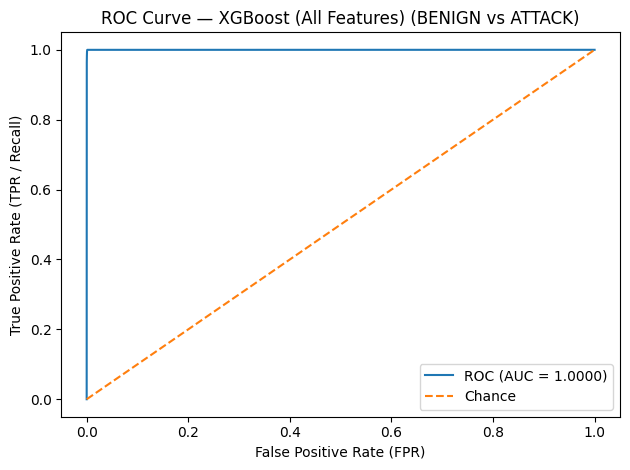

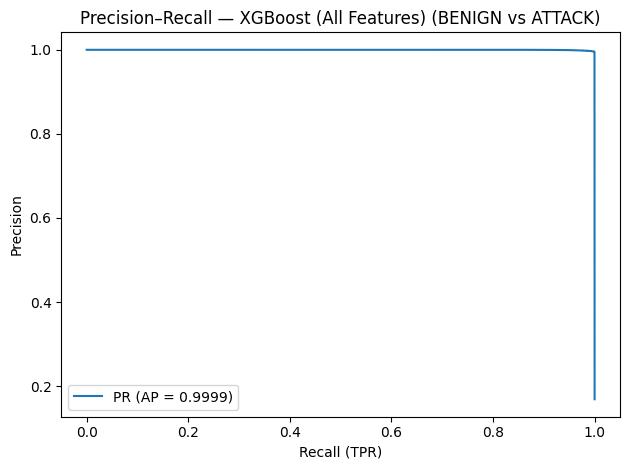

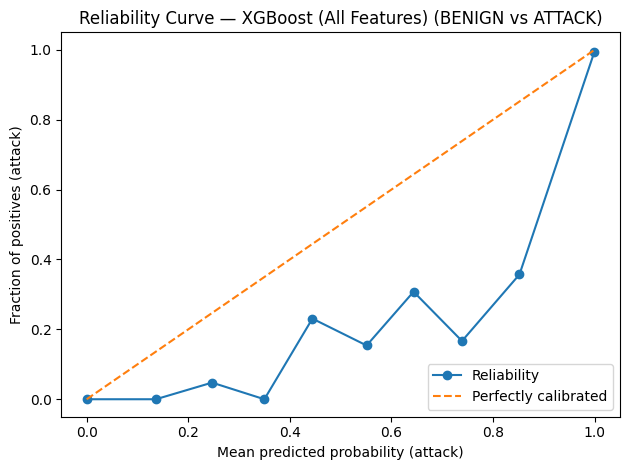

Average Precision (Attack): 0.999878


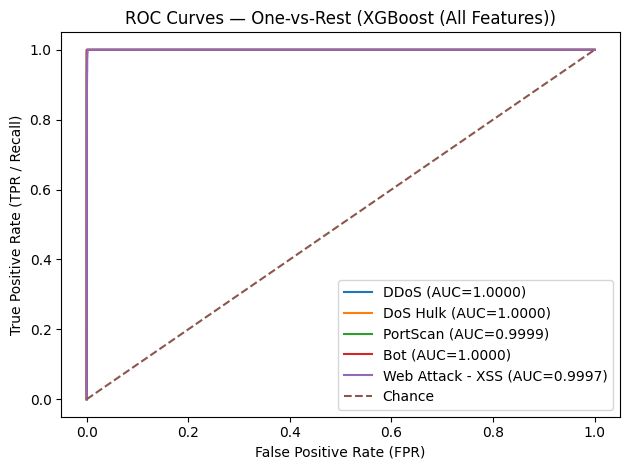

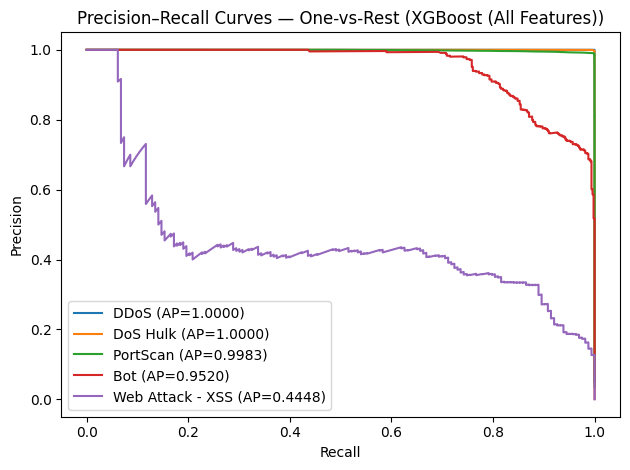

In [12]:
# Evaluation of XGBoost (All Features)
SHOW_PLOTS_XGB_ALL = True # Toggle plots

if "xgb_all_paper" not in globals():
    print("xgb_all_paper not found. Run the training cell first.")
else:
    y_pred_xgb_all_paper_eval = xgb_all_paper.predict(X_test_model)
    y_proba_xgb_all_paper_eval = xgb_all_paper.predict_proba(X_test_model)
    summary_xgb_all_paper, per_class_xgb_all_paper = evaluate_model(
        name="XGBoost (All Features)",
        X_test=X_test_model,
        y_true=y_test,
        y_pred=y_pred_xgb_all_paper_eval,
        y_proba=y_proba_xgb_all_paper_eval,
        class_names=class_names,
        benign_label="BENIGN",
        selected_labels=SELECTED_LABELS,
        show_plots=SHOW_PLOTS_XGB_ALL
    )

## 4.3. Random Forest + XGBoost Evaluation

This cell evaluates the trained RF-selected-features XGBoost model (using the best TOP_K from the sweep) on the test set, computing predictions and probabilities, then generating the full metric summary (F1, balanced accuracy, AUC, confusion matrix) via the evaluate_model helper.


------------------ RF to XGBoost (Selected Features) — BEST_TOP_K=80 ------------------
Accuracy: 0.99856
Macro F1: 0.914594
Weighted F1: 0.998601
Balanced Accuracy: 0.94361
Cohen's Kappa: 0.995222
Matthews Corrcoef (MCC): 0.995228

Classification report:
                            precision    recall  f1-score   support

                    BENIGN     1.0000    0.9988    0.9994    524121
                       Bot     0.6831    0.9939    0.8097       488
                      DDoS     0.9997    1.0000    0.9998     32004
             DoS GoldenEye     0.9854    0.9988    0.9921      2572
                  DoS Hulk     0.9965    0.9992    0.9979     43212
          DoS SlowHTTPTest     0.9826    0.9954    0.9890      1307
             DoS Slowloris     0.9918    0.9926    0.9922      1346
               FTP-Patator     0.9993    0.9993    0.9993      1483
                Heartbleed     1.0000    1.0000    1.0000         3
              Infiltration     0.9000    1.0000    0.9474     

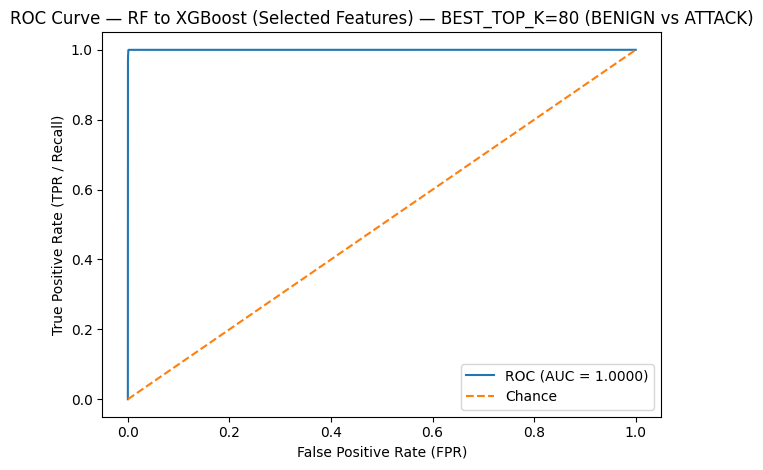

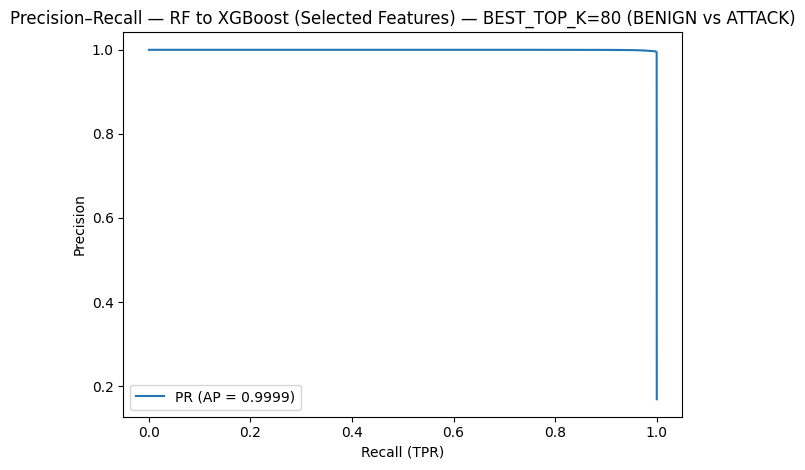

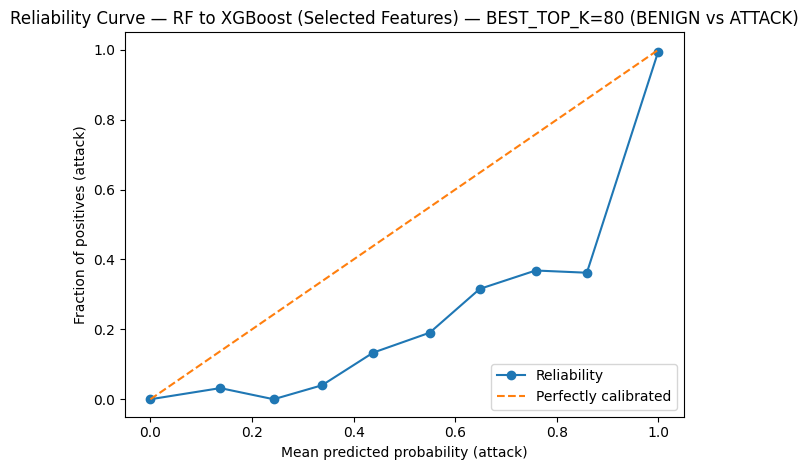

Average Precision (Attack): 0.999879


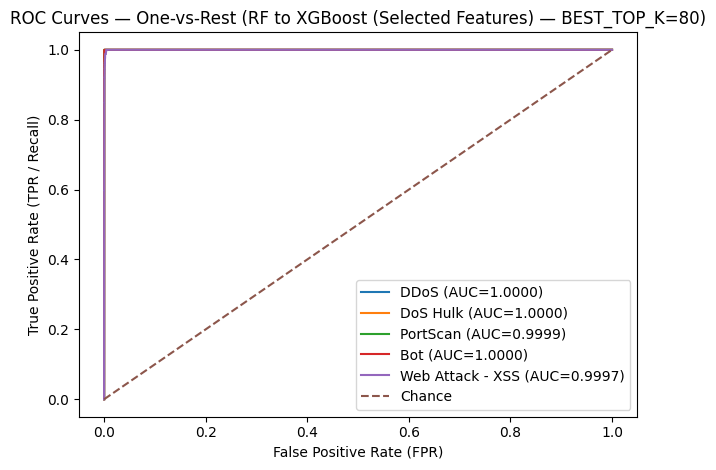

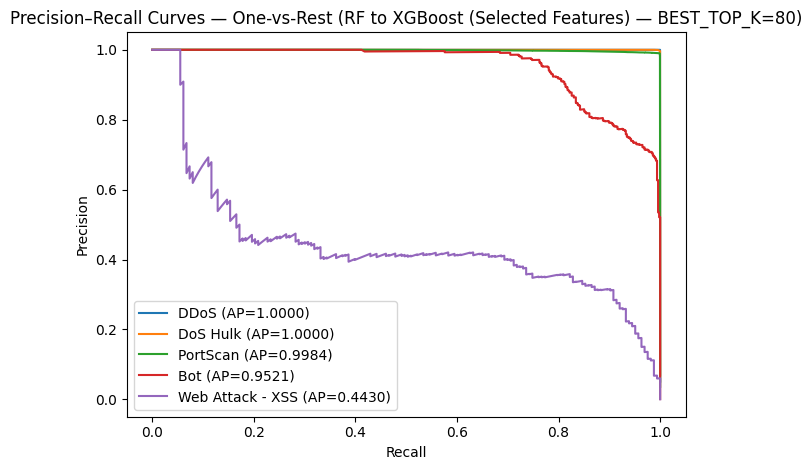

In [13]:
# Evaluation of Random Forest to XGBoost (RF-selected Features + BEST_TOP_K from sweep)
SHOW_PLOTS_RF_XGB = True # Toggle plots

if "rf_xgb_bestk_model" not in globals():
    print("rf_xgb_bestk_model not found. Run the training cell first.")
elif "X_test_rf_xgb_bestk" not in globals():
    print("X_test_rf_xgb_bestk not found. Run the training cell first.")
else:
    y_pred_rf_xgb_bestk_eval = rf_xgb_bestk_model.predict(X_test_rf_xgb_bestk)
    y_proba_rf_xgb_bestk_eval = rf_xgb_bestk_model.predict_proba(X_test_rf_xgb_bestk)
    summary_rf_xgb_bestk, per_class_rf_xgb_bestk = evaluate_model(
        name=f"RF to XGBoost (Selected Features) — BEST_TOP_K={RF_XGB_BEST_TOP_K}",
        X_test=X_test_rf_xgb_bestk,
        y_true=y_test,
        y_pred=y_pred_rf_xgb_bestk_eval,
        y_proba=y_proba_rf_xgb_bestk_eval,
        class_names=class_names,
        benign_label="BENIGN",
        selected_labels=SELECTED_LABELS,
        show_plots=SHOW_PLOTS_RF_XGB
    )

## 4.4. Comparison Summary

This cell builds a side-by-side table comparing the evaluation summaries for the two models (XGBoost on all features vs RF-selected features + XGBoost). It checks that both summary dictionaries exist, then displays their key metrics in a single dataframe for easy comparison.

In [14]:
needed = ["summary_xgb_all_paper", "summary_rf_xgb_bestk"]
missing = [v for v in needed if v not in globals()]

if missing:
    print("Missing summaries:", missing)
    print("Run the model evaluation cells first (XGB all-features evaluation and RF + XGB evaluation)")
else:
    summary_df = pd.DataFrame([summary_xgb_all_paper, summary_rf_xgb_bestk]).set_index("model")
    print("\n---- Summary Comparison Table ----")
    display(summary_df)


---- Summary Comparison Table ----


,accuracy,macro_f1,weighted_f1,balanced_accuracy,kappa,mcc,multiclass_logloss,attack_logloss,attack_brier,macro_sensitivity,weighted_sensitivity,macro_specificity,weighted_specificity,macro_threat_score,weighted_threat_score
model,,,,,,,,,,,,,,,
XGBoost (All Features),0.998655,0.913488,0.998692,0.942018,0.995537,0.995541,0.006491,0.005225,0.000902,0.942018,0.998655,0.999901,0.999864,0.870976,0.997613
RF to XGBoost (Selected Features) — BEST_TOP_K=80,0.998560,0.914594,0.998601,0.943610,0.995222,0.995228,0.006665,0.005379,0.000968,0.943610,0.998560,0.999895,0.999858,0.871660,0.997425


## 4.5. Split Ratio Sensitivity Check (75/25 vs 70/30 vs 67/33)

This cell reruns the RF feature selection + XGBoost training pipeline under multiple train/test ratios (75/25, 70/30, 67/33) to check whether performance is stable across different splits. It reports core multiclass metrics plus operational BENIGN-vs-ATTACK rates (TP/FP/TN/FN, TPR/FPR, AUC/AP), and flags if any classes are missing in train or test due to class imbalance.

In [15]:
# Configuration
MAX_W = 1000 # Weight cap
EPS = 1e-12  # Tiny constant

# Use BEST_TOP_K found by the RF to XGB sweep
if "RF_XGB_BEST_TOP_K" not in globals():
    raise NameError("RF_XGB_BEST_TOP_K not found. Run the training cell first.")
TOP_K = int(RF_XGB_BEST_TOP_K)
print("Using TOP_K from sweep:", TOP_K)

SPLITS = [
    ("75/25", 0.25),
    ("70/30", 0.30),
    ("67/33", 0.33)
]

def safe_multiclass_auc_ovr(y_true, y_proba, n_classes):
    # Macro/weighted OvR AUC strong for missing classes
    y_true = np.asarray(y_true)
    present = np.unique(y_true)
    if len(present) < 2:
        return np.nan, np.nan
    classes = np.arange(n_classes)
    y_bin = label_binarize(y_true, classes=classes)
    aucs = []
    weights = []
    for i in range(n_classes):
        y_i = y_bin[:, i]
        # Need both positives and negatives
        if np.all(y_i == 0) or np.all(y_i == 1):
            continue
        aucs.append(roc_auc_score(y_i, y_proba[:, i]))
        weights.append(y_i.sum())
    if len(aucs) == 0:
        return np.nan, np.nan
    aucs = np.asarray(aucs)
    weights = np.asarray(weights, dtype=float)
    return float(np.mean(aucs)), float(np.average(aucs, weights=weights))

def summary_from_preds(y_true, y_pred, y_proba, class_names):
    n_classes = len(class_names)
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    weighted_f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    total = cm.sum()
    tp = np.diag(cm)
    fn = cm.sum(axis=1) - tp
    fp = cm.sum(axis=0) - tp
    tn = total - (tp + fn + fp)
    sens = tp / (tp + fn + EPS)
    spec = tn / (tn + fp + EPS)
    ts = tp / (tp + fn + fp + EPS)  # Threat Score / CSI
    support = cm.sum(axis=1).astype(float)
    w = support / (support.sum() + EPS)
    auc_macro, auc_weighted = (np.nan, np.nan)
    if y_proba is not None:
        auc_macro, auc_weighted = safe_multiclass_auc_ovr(y_true, y_proba, n_classes)
    out = {
        "Accuracy": acc,
        "Macro F1": macro_f1,
        "Weighted F1": weighted_f1,
        "Balanced Acc": bal_acc,
        "Kappa": kappa,
        "MCC": mcc,
        "Macro Sensitivity": float(np.mean(sens)),
        "Weighted Sensitivity": float(np.sum(w * sens)),
        "Macro Specificity": float(np.mean(spec)),
        "Weighted Specificity": float(np.sum(w * spec)),
        "Macro Threat Score": float(np.mean(ts)),
        "Weighted Threat Score": float(np.sum(w * ts)),
        "OvR AUC (macro)": auc_macro,
        "OvR AUC (weighted)": auc_weighted,
    }
    # Operational BENIGN vs ATTACK metrics
    if "BENIGN" in class_names and y_proba is not None:
        benign_idx = int(np.where(class_names == "BENIGN")[0][0])
        y_attack = (y_true != benign_idx).astype(int)
        p_attack = 1.0 - y_proba[:, benign_idx]
        # argmax TP/FP/TN/FN at operational point
        y_pred_attack = (y_pred != benign_idx).astype(int)
        tn_b, fp_b, fn_b, tp_b = confusion_matrix(y_attack, y_pred_attack).ravel()
        out.update({
            "Attack TP": int(tp_b),
            "Attack FP": int(fp_b),
            "Attack TN": int(tn_b),
            "Attack FN": int(fn_b),
            "Attack TPR": float(tp_b / (tp_b + fn_b + EPS)),
            "Attack FPR": float(fp_b / (fp_b + tn_b + EPS)),
            "Attack Precision": float(tp_b / (tp_b + fp_b + EPS)),
            "Attack Specificity": float(tn_b / (tn_b + fp_b + EPS)),
            "Attack Threat Score": float(tp_b / (tp_b + fn_b + fp_b + EPS)),
            "Attack ROC-AUC": float(roc_auc_score(y_attack, p_attack)) if len(np.unique(y_attack)) > 1 else np.nan,
            "Attack AP": float(average_precision_score(y_attack, p_attack)) if len(np.unique(y_attack)) > 1 else np.nan,
        })
    return out

def run_rf_xgb_paper(test_size):
    # Split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        shuffle=True,
        random_state=RANDOM_STATE
    )
    # Scale (fit on train only)
    scaler = MinMaxScaler()
    X_tr = pd.DataFrame(scaler.fit_transform(X_tr), columns=X.columns, index=X_tr.index)
    X_te = pd.DataFrame(scaler.transform(X_te), columns=X.columns, index=X_te.index)
    # Sample weights (same as your split cell)
    train_counts = np.bincount(y_tr, minlength=n_classes)
    class_weights = (len(y_tr) / (n_classes * np.maximum(train_counts, 1)))
    sw_tr = np.clip(class_weights[y_tr], 0, MAX_W)
    # RF for feature importances
    rf = RandomForestClassifier(
        n_estimators=RF_TREES,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        class_weight=None
    )
    rf.fit(X_tr, y_tr, sample_weight=sw_tr)
    importances = pd.Series(rf.feature_importances_, index=X_tr.columns).sort_values(ascending=False)
    top_features = importances.index[:TOP_K].tolist()
    X_tr_sel = X_tr.loc[:, top_features]
    X_te_sel = X_te.loc[:, top_features]
    # XGB model
    xgb = XGBClassifier(
        objective="multi:softprob",
        num_class=n_classes,
        eval_metric="mlogloss",
        tree_method="hist",
        n_estimators=500,
        max_depth=6,
        learning_rate=0.1,
        subsample=1.0,
        colsample_bytree=1.0,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    xgb.fit(X_tr_sel, y_tr, sample_weight=sw_tr)
    y_pred = xgb.predict(X_te_sel)
    y_proba = xgb.predict_proba(X_te_sel)
    missing_train = int(np.sum(np.bincount(y_tr, minlength=n_classes) == 0))
    missing_test  = int(np.sum(np.bincount(y_te, minlength=n_classes) == 0))
    return y_te, y_pred, y_proba, missing_train, missing_test

rows = []
for split_name, test_size in SPLITS:
    t0 = time.time()
    y_te, y_pred, y_proba, miss_tr, miss_te = run_rf_xgb_paper(test_size=test_size)
    metrics = summary_from_preds(y_te, y_pred, y_proba, class_names=np.asarray(class_names))
    metrics["Split"] = split_name
    metrics["Missing classes in train"] = miss_tr
    metrics["Missing classes in test"] = miss_te
    metrics["Runtime (sec)"] = round(time.time() - t0, 2)
    rows.append(metrics)
split_df = pd.DataFrame(rows).set_index("Split")

preferred_order = [
    "Accuracy", "Macro F1", "Balanced Acc", "Kappa", "MCC",
    "Macro Sensitivity", "Macro Specificity", "Macro Threat Score",
    "Weighted Sensitivity", "Weighted Specificity", "Weighted Threat Score",
    "OvR AUC (macro)", "OvR AUC (weighted)",
    "Missing classes in train", "Missing classes in test", "Runtime (sec)"
]
ordered_cols = [c for c in preferred_order if c in split_df.columns] + [c for c in split_df.columns if c not in preferred_order]
split_df = split_df[ordered_cols] # Re-order columns

print("\n---- Split Ratio Sensitivity (RF-to-XGB) ----")
display(split_df) # Show results

Using TOP_K from sweep: 80

---- Split Ratio Sensitivity (RF-to-XGB) ----


,Accuracy,Macro F1,Balanced Acc,Kappa,MCC,Macro Sensitivity,Macro Specificity,Macro Threat Score,Weighted Sensitivity,Weighted Specificity,...,Attack FP,Attack TN,Attack FN,Attack TPR,Attack FPR,Attack Precision,Attack Specificity,Attack Threat Score,Attack ROC-AUC,Attack AP
Split,,,,,,,,,,,,,,,,,,,,,
75/25,0.998560,0.914594,0.943610,0.995222,0.995228,0.943610,0.999895,0.871660,0.998560,0.999858,...,639,523482,14,0.999869,0.001219,0.994033,0.998781,0.993903,0.999976,0.999879
70/30,0.998560,0.914097,0.944959,0.995221,0.995226,0.944959,0.999895,0.870707,0.998560,0.999869,...,781,628164,15,0.999883,0.001242,0.993924,0.998758,0.993808,0.999974,0.999871
67/33,0.998549,0.921156,0.947045,0.995185,0.995191,0.947045,0.999894,0.880163,0.998549,0.999859,...,864,690976,18,0.999872,0.001249,0.993889,0.998751,0.993763,0.999973,0.999863


## 4.6. Overfitting Check

This cell compares Macro-F1 on the training set vs the held-out test set for both models (XGBoost on all features and RF-selected-features + XGBoost). A much higher training score than test score can indicate overfitting, while similar scores suggest better generalisation. It also recomputes predictions each run to avoid using stale outputs.

In [16]:
if "xgb_all_paper" in globals():
    train_pred = xgb_all_paper.predict(X_train_model) # Recompute pred to avoid stale outputs
    test_pred  = xgb_all_paper.predict(X_test_model)
    print("XGBoost (All Features)")
    print("  Train Macro F1:", f1_score(y_train, train_pred, average="macro"))
    print("  Test  Macro F1:", f1_score(y_test,  test_pred,  average="macro"))
else:
    print("xgb_all_paper not found. Run training cell first.")

if "rf_xgb_bestk_model" in globals():
    train_pred = rf_xgb_bestk_model.predict(X_train_rf_xgb_bestk)
    test_pred  = rf_xgb_bestk_model.predict(X_test_rf_xgb_bestk)
    print(f"\nRF + XGBoost (Selected Features) — BEST_TOP_K={RF_XGB_BEST_TOP_K}")
    print("  Train Macro F1:", f1_score(y_train, train_pred, average="macro"))
    print("  Test  Macro F1:", f1_score(y_test,  test_pred,  average="macro"))
else:
    print("rf_xgb_bestk_model not found. Run training cell first.")

XGBoost (All Features)
  Train Macro F1: 0.984838816191811
  Test  Macro F1: 0.9134875602905458

RF + XGBoost (Selected Features) — BEST_TOP_K=80
  Train Macro F1: 0.9847711388462018
  Test  Macro F1: 0.9145944829570607
